In [1]:
!pip install lmfit

     |████████████████████████████████| 292 kB 4.2 MB/s 
     |████████████████████████████████| 98 kB 4.4 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84401 sha256=726129adddd57bb9ddd7fd2fd5d8dbcdccf2dc7a66f9ac6b8314c36006a6427e
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
  Created wheel for asteval: filename=asteval-0.9.25-py3-none-any.whl size=17301 sha256=d10537a66b0cdbe6edcf64c39cef9817fe33dd0ccbd34b9e5a9842f9465b8a7f
  Stored in directory: /root/.cache/pip/wheels/4a/87/53/f1385a55b3f60eabb921c5f4fd151c00fdb016b5111b8c830f
Successfully built lmfit asteval


Starting Experiment: 1 / 10


100%|██████████| 150/150 [00:00<00:00, 179.62it/s]


Starting Experiment: 2 / 10


100%|██████████| 150/150 [00:00<00:00, 172.65it/s]


Starting Experiment: 3 / 10


100%|██████████| 150/150 [00:00<00:00, 168.94it/s]


Starting Experiment: 4 / 10


100%|██████████| 150/150 [00:00<00:00, 175.01it/s]


Starting Experiment: 5 / 10


100%|██████████| 150/150 [00:00<00:00, 186.44it/s]


Starting Experiment: 6 / 10


100%|██████████| 150/150 [00:00<00:00, 180.76it/s]


Starting Experiment: 7 / 10


100%|██████████| 150/150 [00:00<00:00, 174.51it/s]


Starting Experiment: 8 / 10


100%|██████████| 150/150 [00:00<00:00, 172.07it/s]


Starting Experiment: 9 / 10


100%|██████████| 150/150 [00:00<00:00, 178.31it/s]


Starting Experiment: 10 / 10


100%|██████████| 150/150 [00:00<00:00, 189.77it/s]


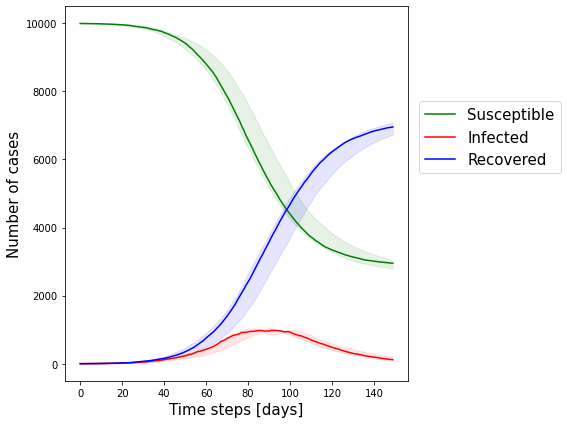

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

from tqdm import tqdm


#Agent based

_nAgents = 10000 #population
state = np.zeros(_nAgents)
data = {"state": state}
df = pd.DataFrame(data)
df.describe()

def infect(df, contacts, probability=1.0):
    unique, counts = np.unique(contacts, return_counts=True)
    
    roll = np.random.uniform(0,1,len(unique))

    state = df.loc[unique,"state"]
    probability = 1 - np.power(1-probability, counts)
    change = np.array(roll <= probability).astype(int)
    
    df.loc[unique,"state"] = state + np.maximum(change*(1-state),0)
    
    
def init(nAgents=1000, nPatientZero=1):
    state = np.zeros(nAgents)

    neighborhood = np.zeros(nAgents)
    data = {"state": state, "neighborhood": neighborhood}

    df = pd.DataFrame(data)
    patientZero = np.random.choice(df.index, nPatientZero, replace=False)
    infect(df, patientZero, probability=1.0)
    return df

def recover(df, probability=1.0):    
    roll = np.random.uniform(0,1,len(df[df["state"] == 1]))
    chance = np.array(roll <= probability).astype(int)
    
    df.loc[df["state"] == 1,"state"] = 1 + chance

def step(df):
    nInfected = np.sum(df["state"] == 1)
    contacts = np.random.choice(df.index, _randomContacts * nInfected, replace=True)

    infect(df, contacts, _chanceOfInfection)
    recover(df, _chanceOfRecovery)
    
def simulate(df, stats, nSteps=100, mode="random", nRandomContacts=0, plotLattice=False):
    for i in tqdm(range(nSteps)):        
        step(df)
            
        stats["nSusceptible"].append(np.sum(df["state"] == 0))    
        stats["nInfected"].append(np.sum(df["state"] == 1))
        stats["nRemoved"].append(np.sum(df["state"] == 2))
        
  
_randomContacts = 10 #number of contacts (susceptible)
_chanceOfInfection = 0.02 #beta
_daysCuredAfter = 10 
_chanceOfRecovery = 1./_daysCuredAfter #gamma

_nExperiments = 10 #number of times the experiment is repeated 
_nAgents = 10000 #population
_nSteps = 150

_nPatientZero = 6 #initial number of infected population

#days
x = np.linspace(0,_nSteps-1,_nSteps)
allStats = []

for iExp in range(_nExperiments):
    print("Starting Experiment:",iExp+1,"/",_nExperiments)
    st = {"nInfected": [], "nRemoved": [], "nSusceptible": []}

    df = init(_nAgents, _nPatientZero)

    simulate(df, stats=st, nSteps=_nSteps)
    
    allStats.append(st)

def calculateStats(allStats):
    medianStats = dict()
    lowerStats = dict()
    higherStats = dict()

    for key in allStats[0]:
        l = []
        for st in allStats:
            l.append(st[key])
        a = np.stack(l)
        medianStats[key] = np.median(a, axis=0)
        lowerStats[key] = np.quantile(a, 0.25, axis=0)
        higherStats[key] = np.quantile(a, 0.75, axis=0)
    
    return medianStats, lowerStats, higherStats

def plotSIR(x,mdianStats,lowerStats,higherStats,figName="tmp.png"):
    fig=plt.figure(figsize=(8, 6))
    plt.plot(x,medianStats["nSusceptible"], color = "green", label="Susceptible")
    plt.plot(x,medianStats["nInfected"], color="red", label="Infected")
    plt.plot(x,medianStats["nRemoved"], color="blue", label="Recovered")
    plt.fill_between(x, lowerStats["nSusceptible"], higherStats["nSusceptible"],
                     color='green', alpha=0.1)
    plt.fill_between(x, lowerStats["nInfected"], higherStats["nInfected"],
                     color='red', alpha=0.1)
    plt.fill_between(x, lowerStats["nRemoved"], higherStats["nRemoved"],
                     color='blue', alpha=0.1)


    plt.xlabel("Time steps [days]",size=15)
    plt.ylabel("Number of cases",size=15)

    lgd = plt.legend(bbox_to_anchor=(1.01,0.65), loc="center left",fontsize=15)
    plt.tight_layout()
    
    plt.savefig(figName, bbox_extra_artists=(lgd,), bbox_inches='tight')
   
    plt.show()

medianStats, lowerStats, higherStats = calculateStats(allStats)
 
 #In this section the data will be saved in files .txt
with open("MedianStats2.txt","w") as f0: 
 for i in range(0, len(list(medianStats["nSusceptible"]))):
    #The data corresponding to MedianStats are stored for each of the cases in three columns 
    f0.write("{0}\t{1}\t{2}\t{3}\n".format(x[i],medianStats["nSusceptible"][i],medianStats["nInfected"][i], medianStats["nRemoved"][i]))
f0.close()

with open("LowerStats2.txt","w") as f1: 
 for i in range(0, len(list(lowerStats["nSusceptible"]))):
    #The data corresponding to lowerStats are saved for each of the cases in three columns 
    f1.write("{0}\t{1}\t{2}\t{3}\n".format(x[i],lowerStats["nSusceptible"][i],lowerStats["nInfected"][i], lowerStats["nRemoved"][i]))
f1.close()

with open("HigherStats2.txt","w") as f2: 
 for i in range(0, len(list(higherStats["nSusceptible"]))):
    #The data corresponding to HigherStats are stored for each of the cases in three columns 
    f2.write("{0}\t{1}\t{2}\t{3}\n".format(x[i],higherStats["nSusceptible"][i],higherStats["nInfected"][i], higherStats["nRemoved"][i]))
f2.close()

plotSIR(x,medianStats,lowerStats,higherStats,figName="SimulacionEst2.png")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 150
    # variables        = 2
    chi-square         = 0.04303144
    reduced chi-square = 2.9075e-04
    Akaike info crit   = -1219.46894
    Bayesian info crit = -1213.44767
[[Variables]]
    x10:  10.19276 (fixed)
    x20:  0.006119327 (fixed)
    x30:  0 (fixed)
    k0:   0.01806078 +/- 2.0282e-05 (0.11%) (init = 0.03)
    k1:   0.10777312 +/- 1.8412e-04 (0.17%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k0, k1) = 0.895


<Figure size 432x288 with 0 Axes>

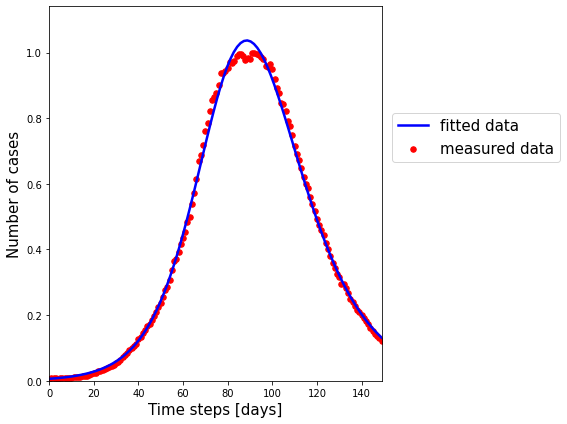

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint


def f(y, t, paras):
    """
    Your system of differential equations
    """

    x1 = y[0] #S
    x2 = y[1] #I
    x3 = y[2] #R

    try:
        k0 = paras['k0'].value #beta (transmission rate)
        k1 = paras['k1'].value #gamma (recovery rate)

    except KeyError:
        k0, k1 = paras
    # the model equations
    f0 = -k0 * x1 * x2 #dS
    f1 = k0 * x1 * x2- k1 * x2 #dI
    f2 = k1 * x2 #dR
    return [f0, f1, f2]


def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(paras,))
    return x


def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['x10'].value, paras['x20'].value, paras['x30'].value
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model[:, 1]
    return (x2_model - data).ravel()


# initial conditions
N = 10000. #Total population
x10 = 9994/980.5 # S(0)
x20 = 6/980.5  # I(0)
x30 = 0.  # R(0)
y0 = [x10, x20, x30]

#Here the stochastic simulation data is substituted 

# measured data
t_measured = list(np.loadtxt("/content/drive/MyDrive/proyectosisdinam/MedianStats2.txt")[:, 0]) 
data = list(np.loadtxt("/content/drive/MyDrive/proyectosisdinam/MedianStats2.txt")[:, 2])
median_measured = list(map(lambda x: x / 980.5, data))
#lower_measured = np.loadtxt("LowerStats.txt")[:, 2]
#higher_measured = np.loadtxt("HigherStats.txt")[:, 2]

plt.figure()
fig=plt.figure(figsize=(8, 6))
plt.scatter(t_measured, median_measured, marker='o', color='r', label='measured data', s=30)

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('k0', value=0.03, min=0.0001, max=2.)
params.add('k1', value=0.1, min=0.0001, max=2.)

# fit model
result = minimize(residual, params, args=(t_measured, median_measured), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(np.linspace(0., 149., 100), y0, result.params)

# plot fitted data
plt.plot(np.linspace(0., 149., 100), data_fitted[:, 1], '-', linewidth=2.5, color='blue', label='fitted data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])
plt.xlabel("Time steps [days]",size=15)
plt.ylabel("Number of cases",size=15)
lgd = plt.legend(bbox_to_anchor=(1.01,0.65), loc="center left",fontsize=15)
plt.tight_layout()
plt.savefig("comparacion2v1.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
# display fitted statistics
report_fit(result)

plt.show()

In [102]:
max(data)

980.5

**SIMULACION**

***Condiciones Iniciales:***


***N=10000***

***Infectados=5***

***Susceptibles=N-5***

***Beta=0.05***

***Gamma=0.1***




---


**MODELO SIR VS ESTOCASTICO**

***Condiciones Iniciales:***


***N=10000***

***Infectados=5***

***Susceptibles=N-5***

***FIT:***

***Beta del fit=0.1080***

***Gamma del fit =0.1082***

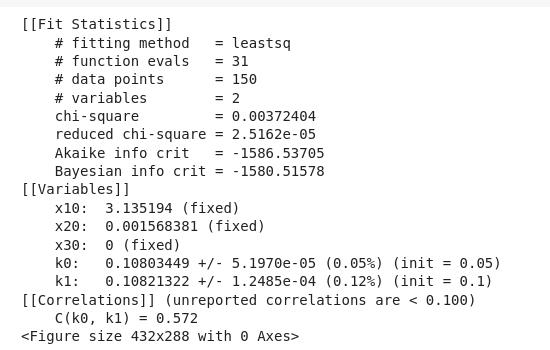

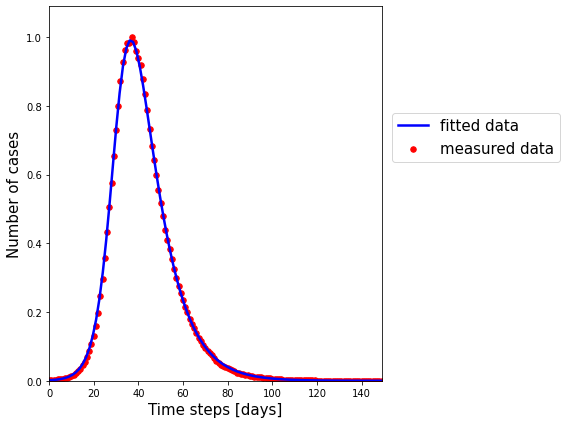

**SIMULACION**

***Condiciones Iniciales:***


***N=10000***

***Infectados=6***

***Susceptibles=N-5***

***Beta=0.02***

***Gamma=0.1***

***Random Contacts=10***



---


**MODELO SIR VS ESTOCASTICO**

***Condiciones Iniciales:***


***N=10000***

***Infectados=6***

***Susceptibles=N-6***

***FIT:***

***Beta del fit=0.01080***

***Gamma del fit =0.1077***

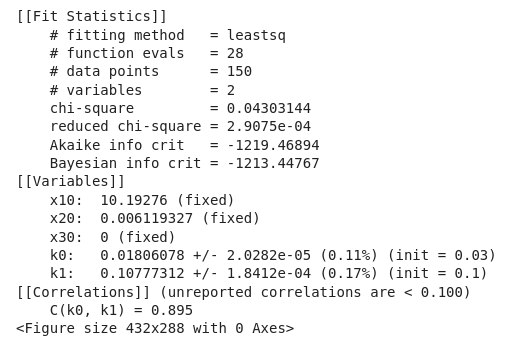

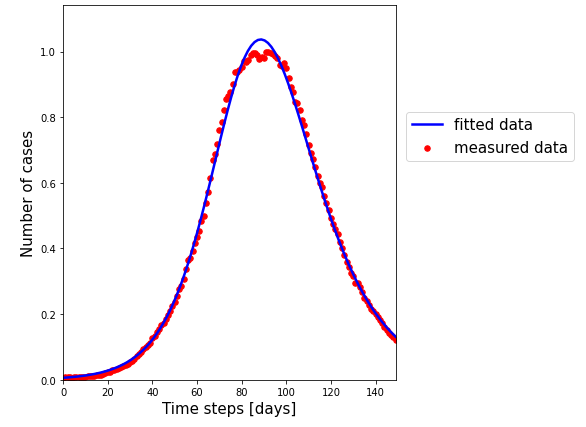